# Lead Scoring Case Study #

#### Importing required libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,precision_score,recall_score

from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

#### Importing the DataSet

In [2]:
leads = pd.read_csv('Leads.csv')

#### Basic Checks on the imported dataset

In [3]:
leads.shape

(9240, 37)

In [4]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

#### Checking the different quartile value for numeric variable

In [5]:
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


#### Cheking the dataset for the amount of nulls present

In [6]:
round(100*(leads.isna().sum()/len(leads.index)),2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   15.56
How did you hear about X Education               23.89
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

#### Doing a check on the columns present

In [7]:
leads.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

#### Lets keep an actual copy of dataset for later analyis

In [8]:
leads_df = leads

### After checking the columns for the variance explained below columns needs to be dropped as it is explaining nearly no variance

In [9]:
# Do Not Call
# What matters most to you in choosing this course
# Magazine
# Newspaper Article
# X Education Forums
# Newspaper
# Digital Advertisement
# Through Recommendations
# Receive More Updates About Our Courses
# Update me on Supply Chain Content
# Get updates on DM Content
# I agree to pay the amount through cheque

In [10]:
low_variance = ['Do Not Call','What matters most to you in choosing a course','Magazine',
                'Newspaper Article','X Education Forums','Newspaper','Digital Advertisement','Through Recommendations'
                ,'Receive More Updates About Our Courses','Update me on Supply Chain Content','Get updates on DM Content'
                ,'I agree to pay the amount through cheque']

leads_df = leads_df.drop(low_variance,axis='columns')

In [11]:
# Also ID columns are of no use needs to be dropped
leads_df = leads_df.drop(['Prospect ID','Lead Number'],axis='columns')

In [12]:
leads_df.shape

(9240, 23)

### Now lets deal with the null values

#### As per problem statement 'Select' is similar to NaN

In [13]:
leads_df.replace('Select',np.NaN,inplace=True)

#### Checking the amount of null values present in the dataset

In [14]:
round(100*(leads_df.isna().sum()/len(leads_df.index)))

Lead Origin                                0.0
Lead Source                                0.0
Do Not Email                               0.0
Converted                                  0.0
TotalVisits                                1.0
Total Time Spent on Website                0.0
Page Views Per Visit                       1.0
Last Activity                              1.0
Country                                   27.0
Specialization                            37.0
How did you hear about X Education        78.0
What is your current occupation           29.0
Search                                     0.0
Tags                                      36.0
Lead Quality                              52.0
Lead Profile                              74.0
City                                      40.0
Asymmetrique Activity Index               46.0
Asymmetrique Profile Index                46.0
Asymmetrique Activity Score               46.0
Asymmetrique Profile Score                46.0
A free copy o

#### Dropping the column with more than 30% Nulls


In [15]:
more_than_30 = list(round(100*(leads_df.isna().sum()/len(leads_df.index)))[round(100*(leads_df.isna().sum()/len(leads_df.index))).values>30.0].index)
leads_df = leads_df.drop(more_than_30,axis='columns')

In [16]:
leads_df.loc[leads_df['Lead Source'].isnull(),'Lead Source'] = 'Google'
leads_df.loc[leads_df['TotalVisits'].isnull(),'TotalVisits'] = 0.0
leads_df.loc[leads_df['Page Views Per Visit'].isnull(),'Page Views Per Visit'] = 0.0
leads_df.loc[leads_df['Last Activity'].isnull(),'Last Activity'] = 'Email Opened'
leads_df.loc[leads_df['Country'].isnull(),'Country'] = 'India'
leads_df.loc[leads_df['What is your current occupation'].isnull(),'What is your current occupation'] = 'Unemployed'

#### Checking the values after imputing

In [17]:
round(100*(leads_df.isnull().sum()/len(leads_df.index)))

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Country                                   0.0
What is your current occupation           0.0
Search                                    0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

#### Lets Check for numerical values for outliers

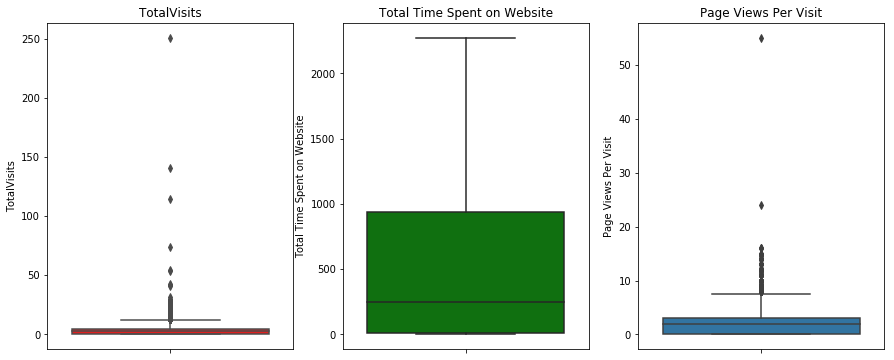

In [18]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
sns.boxplot(y = leads_df.TotalVisits,color='red')
plt.title('TotalVisits')

plt.subplot(1,3,2)
sns.boxplot(y = leads_df['Total Time Spent on Website'],color='green')
plt.title('Total Time Spent on Website')

plt.subplot(1,3,3)
sns.boxplot(y = leads_df['Page Views Per Visit'])
plt.title('Page Views Per Visit')

plt.show()

#### Removing outliers using  1.5 quartile rule

In [19]:
TotalVisits_q1 = leads_df.TotalVisits.quantile(.25)
TotalVisits_q3 = leads_df.TotalVisits.quantile(.75)
TotalVisits_IQR = TotalVisits_q3-TotalVisits_q1

leads_df = leads_df[(leads_df.TotalVisits >= TotalVisits_q1-(TotalVisits_IQR*1.5)) & (leads_df.TotalVisits<=TotalVisits_q3+(TotalVisits_IQR*1.5))]

Website_Q1  = leads_df['Total Time Spent on Website'].quantile(0.25)
Website_Q3 = leads_df['Total Time Spent on Website'].quantile(0.75)
Website_IQR = Website_Q3-Website_Q1

leads_df = leads_df[(leads_df['Total Time Spent on Website']>=Website_Q1-(Website_IQR*1.5)) & (leads_df['Total Time Spent on Website']<=Website_Q3+(Website_IQR*1.5))]

Visit_Q1 = leads_df['Page Views Per Visit'].quantile(.25)
Visit_Q3 = leads_df['Page Views Per Visit'].quantile(.75)
Visit_IQR  = Visit_Q3-Visit_Q1

leads_df = leads_df[(leads_df['Page Views Per Visit']>=Visit_Q1-(Visit_IQR*1.5))&(leads_df['Page Views Per Visit']<=Visit_Q3+(Visit_IQR*1.5))]

#### Lets check the distribution plot for these variables

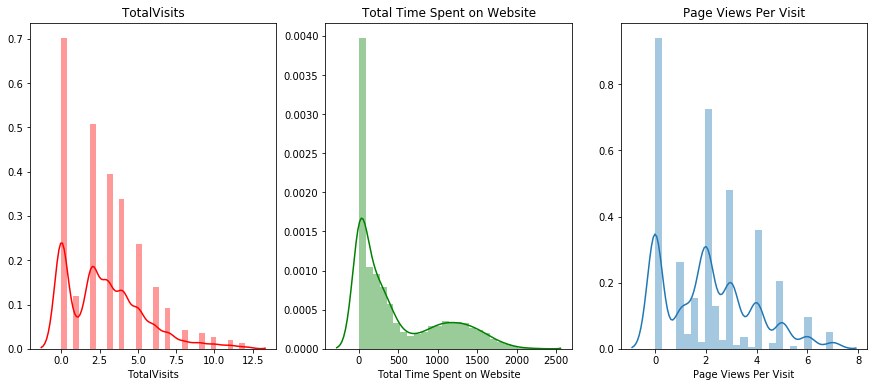

In [20]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
sns.distplot(leads_df.TotalVisits,color='red')
plt.title('TotalVisits')

plt.subplot(1,3,2)
sns.distplot(leads_df['Total Time Spent on Website'],color='green')
plt.title('Total Time Spent on Website')

plt.subplot(1,3,3)
sns.distplot(leads_df['Page Views Per Visit'])
plt.title('Page Views Per Visit')

plt.show()

#### Here we can see our data is not normally distributed

#### Checking the correlation for the numeric variables

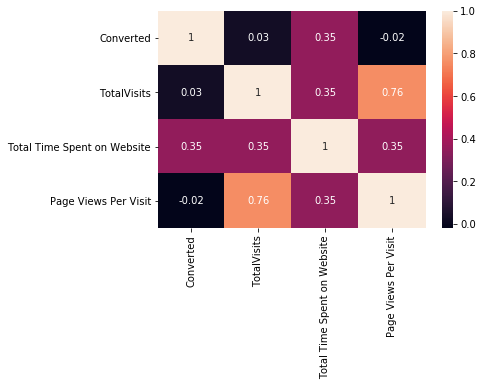

In [21]:
sns.heatmap(leads_df.corr(),annot = True)

#### Now lets convert the binary catagorical features to 0 and 1

In [22]:
cat_bin = ['Do Not Email','Search','A free copy of Mastering The Interview']

def conv_bin(x):
    return x.map({'No':0,'Yes':1})

leads_df[cat_bin] = leads_df[cat_bin].apply(conv_bin)

#### Now lets handle the Nominal variable

In [23]:
leads_df[list(leads_df.dtypes[leads_df.dtypes=='object'].index)].head()

,Lead Origin,Lead Source,Last Activity,Country,What is your current occupation,Last Notable Activity
0,API,Olark Chat,Page Visited on Website,India,Unemployed,Modified
1,API,Organic Search,Email Opened,India,Unemployed,Email Opened
2,Landing Page Submission,Direct Traffic,Email Opened,India,Student,Email Opened
3,Landing Page Submission,Direct Traffic,Unreachable,India,Unemployed,Modified
4,Landing Page Submission,Google,Converted to Lead,India,Unemployed,Modified


In [24]:
nom_var = list(leads_df.dtypes[leads_df.dtypes=='object'].index)
nom_var

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Country',
 'What is your current occupation',
 'Last Notable Activity']

#### Creating the dummy variables

In [25]:
Lead_Origin = pd.get_dummies(leads_df['Lead Origin'],prefix='Lead Origin',drop_first=True)
Lead_Source = pd.get_dummies(leads_df['Lead Source'],prefix='Lead Source',drop_first=True)
Last_Activity = pd.get_dummies(leads_df['Last Activity'],prefix='Last Activity',drop_first=True)
Country = pd.get_dummies(leads_df['Country'],prefix='Country',drop_first=True)
What_is_your_current_occupation = pd.get_dummies(leads_df['What is your current occupation'],
                                                 prefix='What is your current occupation',drop_first=True)
Last_Notable_Activity = pd.get_dummies(leads_df['Last Notable Activity'],prefix='Last Notable Activity',drop_first=True)

#### Joining the dummy with actual dataframe

In [26]:
leads_df = pd.concat([leads_df,Lead_Origin],axis='columns')
leads_df = pd.concat([leads_df,Lead_Source],axis='columns')
leads_df = pd.concat([leads_df,Last_Activity],axis='columns')
leads_df = pd.concat([leads_df,Country],axis='columns')
leads_df = pd.concat([leads_df,What_is_your_current_occupation],axis='columns')
leads_df = pd.concat([leads_df,Last_Notable_Activity],axis='columns')

#### Dropping the actual columns which have been converted to dummy

In [27]:
leads_df = leads_df.drop(['Lead Origin','Lead Source','Last Activity','Country',
                    'What is your current occupation','Last Notable Activity'],axis='columns')

In [28]:
leads_y = leads_df.pop('Converted')
leads_X = leads_df

#### Splitting the data into train and test dataset

In [29]:
train_X,test_X,train_y,test_y = train_test_split(leads_X,leads_y,train_size=0.7,test_size=0.3,random_state=42)

#### Scaling using MinMax Scaler

In [30]:
scale_col = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']
scaler = MinMaxScaler()
train_X[scale_col] = scaler.fit_transform(train_X[scale_col])

#### Checking the Class Imbalence between converted and non converted leads

In [31]:
round(100*(leads_y.sum()/len(leads_y)),2)

38.36

## Feature Selection using RFE

In [32]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression()

In [33]:
rfe = RFE(lreg,20)
rfe = rfe.fit(train_X,train_y)

In [34]:
list(zip(train_X.columns,rfe.support_,rfe.ranking_))

[('Do Not Email', True, 1),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Search', False, 43),
 ('A free copy of Mastering The Interview', False, 67),
 ('Lead Origin_Landing Page Submission', False, 42),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 44),
 ('Lead Origin_Quick Add Form', False, 75),
 ('Lead Source_Direct Traffic', False, 17),
 ('Lead Source_Facebook', False, 18),
 ('Lead Source_Google', False, 20),
 ('Lead Source_Live Chat', False, 51),
 ('Lead Source_NC_EDM', False, 32),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 19),
 ('Lead Source_Pay per Click Ads', False, 48),
 ('Lead Source_Press_Release', False, 66),
 ('Lead Source_Reference', False, 33),
 ('Lead Source_Referral Sites', False, 16),
 ('Lead Source_Social Media', False, 2),
 ('Lead Source_WeLearn', False, 83),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 25),
 ('

In [35]:
col  = train_X.columns[rfe.support_]

#### Creating function to calculate VIF

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(df):
    vif = pd.DataFrame()
    X = df
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF',ascending = False)
    return vif

### Model Building

In [37]:
import statsmodels.api as sm

In [38]:
# Model 1
X_train_m1 = train_X[col]
X_train_m1 = sm.add_constant(X_train_m1)
logm1 = sm.GLM(train_y,X_train_m1,family=sm.families.Binomial()).fit()
logm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6169
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2515.9
Date:                Mon, 10 Jun 2019   Deviance:                       5031.8
Time:                        19:32:45   Pearson chi2:                 7.26e+03
No. Iterations:                    22   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.2596      0.669     -1.882      0.060      -2.571       0.052
Do Not Email                                            -1.3441      0.194     -6.922      0.000      -1.725      -0.964
TotalVisits                                              1.3405      0.245      5.461      0.000       0.859       1.822
Total Time Spent on Website                              4.5842      0.170     27.008      0.000       4.252       4.917
Page Views Per Visit                                    -0.9738      0.233     -4.188      0.000      -1.430      -0.518
Lead Origin_Lead Add Form                                3.7996      0.222     17.102      0.000       3.364       4.235
Lead Source_Olark Chat                                   1.2043      0.136      8.871      0.000       0.938       1.470
Lead Source_Welingak Website                             2.8113      1.029      2.733      0.006       0.795       4.828
Last Activity_Converted to Lead                         -1.1190      0.220     -5.087      0.000      -1.550      -0.688
Last Activity_Email Bounced                             -0.8061      0.364     -2.213      0.027      -1.520      -0.092
Last Activity_Form Submitted on Website                 -0.8169      0.360     -2.267      0.023      -1.523      -0.111
Last Activity_Olark Chat Conversation                   -1.5171      0.167     -9.110      0.000      -1.844      -1.191
Country_Italy                                          -25.1021   4.73e+04     -0.001      1.000   -9.27e+04    9.26e+04
Country_Nigeria                                        -23.0264    3.4e+04     -0.001      0.999   -6.67e+04    6.67e+04
What is your current occupation_Housewife               22.8669   2.13e+04      0.001      0.999   -4.16e+04    4.17e+04
What is your current occupation_Student                 -0.7078      0.695     -1.019      0.308      -2.069       0.654
What is your current occupation_Unemployed              -1.1535      0.660     -1.747      0.081      -2.448       0.141
What is your current occupation_Working Professional     1.7637      0.690      2.558      0.011       0.412       3.115
Last Notable Activity_Had a Phone Conversation          24.2375   2.06e+04      0.001      0.999   -4.03e+04    4.04e+04
Last Notable Activity_SMS Sent                           1.6171      0.083     19.496      0.000       1.455       1.780
Last Notable Activity_Unreachable                        2.0521      0.568      3.616      0.000       0.940       3.164
========================================================================================================================
"""

In [39]:
# Model 2 (Dropping Country_Italy as this is insignificant)
X_train_m2 = X_train_m1.drop('Country_Italy',axis='columns')
X_train_m2 = sm.add_constant(X_train_m2)
logm2 = sm.GLM(train_y,X_train_m2,family=sm.families.Binomial()).fit()
logm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6170
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2519.0
Date:                Mon, 10 Jun 2019   Deviance:                       5038.0
Time:                        19:32:45   Pearson chi2:                 7.26e+03
No. Iterations:                    22   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.2597      0.669     -1.883      0.060      -2.571       0.051
Do Not Email                                            -1.3403      0.194     -6.907      0.000      -1.721      -0.960
TotalVisits                                              1.3393      0.245      5.461      0.000       0.859       1.820
Total Time Spent on Website                              4.5745      0.169     26.989      0.000       4.242       4.907
Page Views Per Visit                                    -0.9640      0.232     -4.150      0.000      -1.419      -0.509
Lead Origin_Lead Add Form                                3.8019      0.222     17.116      0.000       3.367       4.237
Lead Source_Olark Chat                                   1.2071      0.136      8.895      0.000       0.941       1.473
Lead Source_Welingak Website                             2.8109      1.029      2.732      0.006       0.795       4.827
Last Activity_Converted to Lead                         -1.1168      0.220     -5.079      0.000      -1.548      -0.686
Last Activity_Email Bounced                             -0.8074      0.364     -2.218      0.027      -1.521      -0.094
Last Activity_Form Submitted on Website                 -0.8161      0.360     -2.266      0.023      -1.522      -0.110
Last Activity_Olark Chat Conversation                   -1.5174      0.166     -9.113      0.000      -1.844      -1.191
Country_Nigeria                                        -23.0215   3.41e+04     -0.001      0.999   -6.68e+04    6.67e+04
What is your current occupation_Housewife               22.8660   2.13e+04      0.001      0.999   -4.16e+04    4.17e+04
What is your current occupation_Student                 -0.7081      0.694     -1.020      0.308      -2.069       0.653
What is your current occupation_Unemployed              -1.1545      0.660     -1.749      0.080      -2.448       0.139
What is your current occupation_Working Professional     1.7630      0.689      2.558      0.011       0.412       3.114
Last Notable Activity_Had a Phone Conversation          24.2339   2.06e+04      0.001      0.999   -4.04e+04    4.04e+04
Last Notable Activity_SMS Sent                           1.6101      0.083     19.442      0.000       1.448       1.772
Last Notable Activity_Unreachable                        2.0511      0.567      3.614      0.000       0.939       3.163
========================================================================================================================
"""

In [40]:
# Model 3 (Dropping Country_Nigeria as this is insignificant )
X_train_m3  = X_train_m2.drop('Country_Nigeria',axis='columns')
X_train_m3 = sm.add_constant(X_train_m3)
logm3 = sm.GLM(train_y,X_train_m3,family=sm.families.Binomial()).fit()
logm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6171
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2520.8
Date:                Mon, 10 Jun 2019   Deviance:                       5041.7
Time:                        19:32:45   Pearson chi2:                 7.26e+03
No. Iterations:                    22   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.2603      0.669     -1.884      0.060      -2.571       0.051
Do Not Email                                            -1.3379      0.194     -6.895      0.000      -1.718      -0.958
TotalVisits                                              1.3453      0.245      5.487      0.000       0.865       1.826
Total Time Spent on Website                              4.5734      0.169     26.991      0.000       4.241       4.906
Page Views Per Visit                                    -0.9688      0.232     -4.171      0.000      -1.424      -0.514
Lead Origin_Lead Add Form                                3.8032      0.222     17.123      0.000       3.368       4.239
Lead Source_Olark Chat                                   1.2087      0.136      8.907      0.000       0.943       1.475
Lead Source_Welingak Website                             2.8108      1.029      2.732      0.006       0.795       4.827
Last Activity_Converted to Lead                         -1.1150      0.220     -5.071      0.000      -1.546      -0.684
Last Activity_Email Bounced                             -0.8083      0.364     -2.220      0.026      -1.522      -0.095
Last Activity_Form Submitted on Website                 -0.8148      0.360     -2.262      0.024      -1.521      -0.109
Last Activity_Olark Chat Conversation                   -1.5173      0.167     -9.113      0.000      -1.844      -1.191
What is your current occupation_Housewife               22.8662   2.13e+04      0.001      0.999   -4.16e+04    4.17e+04
What is your current occupation_Student                 -0.7077      0.694     -1.019      0.308      -2.068       0.653
What is your current occupation_Unemployed              -1.1552      0.660     -1.750      0.080      -2.449       0.138
What is your current occupation_Working Professional     1.7637      0.689      2.559      0.010       0.413       3.114
Last Notable Activity_Had a Phone Conversation          24.2357   2.06e+04      0.001      0.999   -4.04e+04    4.04e+04
Last Notable Activity_SMS Sent                           1.6081      0.083     19.430      0.000       1.446       1.770
Last Notable Activity_Unreachable                        2.0524      0.567      3.617      0.000       0.940       3.165
========================================================================================================================
"""

In [41]:
# Model 4 (Dropping What is your current occupation_Housewife as it is insignificant)
X_train_m4 = X_train_m3.drop('What is your current occupation_Housewife',axis='columns')
X_train_m4 = sm.add_constant(X_train_m4)
logm4 = sm.GLM(train_y,X_train_m4,family=sm.families.Binomial()).fit()
logm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6172
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2523.8
Date:                Mon, 10 Jun 2019   Deviance:                       5047.7
Time:                        19:32:45   Pearson chi2:                 7.27e+03
No. Iterations:                    21   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4380      0.589     -0.744      0.457      -1.592       0.716
Do Not Email                                            -1.3381      0.194     -6.896      0.000      -1.718      -0.958
TotalVisits                                              1.3356      0.245      5.449      0.000       0.855       1.816
Total Time Spent on Website                              4.5679      0.169     26.980      0.000       4.236       4.900
Page Views Per Visit                                    -0.9693      0.232     -4.175      0.000      -1.424      -0.514
Lead Origin_Lead Add Form                                3.7988      0.222     17.116      0.000       3.364       4.234
Lead Source_Olark Chat                                   1.2023      0.136      8.867      0.000       0.937       1.468
Lead Source_Welingak Website                             2.8100      1.029      2.732      0.006       0.794       4.826
Last Activity_Converted to Lead                         -1.1171      0.220     -5.082      0.000      -1.548      -0.686
Last Activity_Email Bounced                             -0.8092      0.364     -2.223      0.026      -1.523      -0.096
Last Activity_Form Submitted on Website                 -0.7846      0.354     -2.218      0.027      -1.478      -0.091
Last Activity_Olark Chat Conversation                   -1.5247      0.167     -9.140      0.000      -1.852      -1.198
What is your current occupation_Student                 -1.5237      0.619     -2.462      0.014      -2.737      -0.311
What is your current occupation_Unemployed              -1.9715      0.580     -3.398      0.001      -3.109      -0.834
What is your current occupation_Working Professional     0.9460      0.612      1.545      0.122      -0.254       2.146
Last Notable Activity_Had a Phone Conversation          23.2353   1.25e+04      0.002      0.999   -2.45e+04    2.45e+04
Last Notable Activity_SMS Sent                           1.6073      0.083     19.428      0.000       1.445       1.769
Last Notable Activity_Unreachable                        2.0518      0.567      3.616      0.000       0.940       3.164
========================================================================================================================
"""

In [42]:
# Model 5 (Dropping Last Notable Activity_Had a Phone Conversation as it is insignificant)
X_train_m5 = X_train_m4.drop('Last Notable Activity_Had a Phone Conversation',axis='columns')
X_train_m5 = sm.add_constant(X_train_m5)
logm5 = sm.GLM(train_y,X_train_m5,family=sm.families.Binomial()).fit()
logm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6173
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2532.4
Date:                Mon, 10 Jun 2019   Deviance:                       5064.9
Time:                        19:32:45   Pearson chi2:                 7.28e+03
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.4423      0.589     -0.751      0.452      -1.596       0.711
Do Not Email                                            -1.3418      0.194     -6.922      0.000      -1.722      -0.962
TotalVisits                                              1.3339      0.244      5.462      0.000       0.855       1.813
Total Time Spent on Website                              4.5567      0.169     26.981      0.000       4.226       4.888
Page Views Per Visit                                    -0.9401      0.231     -4.062      0.000      -1.394      -0.487
Lead Origin_Lead Add Form                                3.7997      0.222     17.132      0.000       3.365       4.234
Lead Source_Olark Chat                                   1.2036      0.135      8.894      0.000       0.938       1.469
Lead Source_Welingak Website                             2.8098      1.029      2.732      0.006       0.794       4.826
Last Activity_Converted to Lead                         -1.1223      0.220     -5.108      0.000      -1.553      -0.692
Last Activity_Email Bounced                             -0.8100      0.364     -2.227      0.026      -1.523      -0.097
Last Activity_Form Submitted on Website                 -0.7925      0.354     -2.242      0.025      -1.485      -0.100
Last Activity_Olark Chat Conversation                   -1.5288      0.167     -9.168      0.000      -1.856      -1.202
What is your current occupation_Student                 -1.5227      0.619     -2.461      0.014      -2.735      -0.310
What is your current occupation_Unemployed              -1.9652      0.580     -3.388      0.001      -3.102      -0.828
What is your current occupation_Working Professional     0.9515      0.612      1.554      0.120      -0.249       2.152
Last Notable Activity_SMS Sent                           1.5975      0.083     19.340      0.000       1.436       1.759
Last Notable Activity_Unreachable                        2.0397      0.567      3.596      0.000       0.928       3.152
========================================================================================================================
"""

In [43]:
# Model 6(Dropping What is your current occupation_Working Professional as it is insignificant)
X_train_m6 = X_train_m5.drop('What is your current occupation_Working Professional',axis='columns')
X_train_m6 = sm.add_constant(X_train_m6)
logm6 = sm.GLM(train_y,X_train_m6,family=sm.families.Binomial()).fit()
logm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6174
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2533.5
Date:                Mon, 10 Jun 2019   Deviance:                       5067.1
Time:                        19:32:45   Pearson chi2:                 7.16e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.4229      0.218      1.944      0.052      -0.004       0.849
Do Not Email                                  -1.3388      0.194     -6.915      0.000      -1.718      -0.959
TotalVisits                                    1.3305      0.244      5.448      0.000       0.852       1.809
Total Time Spent on Website                    4.5543      0.169     26.975      0.000       4.223       4.885
Page Views Per Visit                          -0.9358      0.231     -4.045      0.000      -1.389      -0.482
Lead Origin_Lead Add Form                      3.7990      0.222     17.129      0.000       3.364       4.234
Lead Source_Olark Chat                         1.2041      0.135      8.901      0.000       0.939       1.469
Lead Source_Welingak Website                   2.8102      1.029      2.732      0.006       0.794       4.826
Last Activity_Converted to Lead               -1.1146      0.219     -5.089      0.000      -1.544      -0.685
Last Activity_Email Bounced                   -0.8066      0.363     -2.220      0.026      -1.519      -0.095
Last Activity_Form Submitted on Website       -0.8302      0.357     -2.324      0.020      -1.530      -0.130
Last Activity_Olark Chat Conversation         -1.5345      0.167     -9.186      0.000      -1.862      -1.207
What is your current occupation_Student       -2.3881      0.289     -8.257      0.000      -2.955      -1.821
What is your current occupation_Unemployed    -2.8306      0.193    -14.638      0.000      -3.210      -2.452
Last Notable Activity_SMS Sent                 1.5990      0.083     19.375      0.000       1.437       1.761
Last Notable Activity_Unreachable              2.0411      0.567      3.600      0.000       0.930       3.152
==============================================================================================================
"""

In [44]:
# As the output for the model is looking fine lets check the VIF
calculate_vif(X_train_m6.drop('const',axis='columns'))

,Feature,VIF
3,Page Views Per Visit,6.58
12,What is your current occupation_Unemployed,5.90
1,TotalVisits,5.57
5,Lead Source_Olark Chat,2.26
2,Total Time Spent on Website,2.09
0,Do Not Email,1.83
8,Last Activity_Email Bounced,1.78
4,Lead Origin_Lead Add Form,1.49
10,Last Activity_Olark Chat Conversation,1.42
13,Last Notable Activity_SMS Sent,1.42


In [45]:
# Model 7 ( Dropping Page Views Per Visit as this is insignifacant for our model)
X_train_m7 = X_train_m6.drop('Page Views Per Visit',axis='columns')
X_train_m7 = sm.add_constant(X_train_m7)
logm7 = sm.GLM(train_y,X_train_m7,family=sm.families.Binomial()).fit()
logm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6190
Model:                            GLM   Df Residuals:                     6175
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2541.8
Date:                Mon, 10 Jun 2019   Deviance:                       5083.6
Time:                        19:32:46   Pearson chi2:                 7.16e+03
No. Iterations:                     7   Covariance Type:             nonrobust
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.1841      0.209      0.880      0.379      -0.226       0.594
Do Not Email                                  -1.3550      0.193     -7.030      0.000      -1.733      -0.977
TotalVisits                                    0.8394      0.213      3.934      0.000       0.421       1.258
Total Time Spent on Website                    4.5473      0.169     26.969      0.000       4.217       4.878
Lead Origin_Lead Add Form                      4.0255      0.215     18.708      0.000       3.604       4.447
Lead Source_Olark Chat                         1.4240      0.125     11.397      0.000       1.179       1.669
Lead Source_Welingak Website                   2.8117      1.029      2.734      0.006       0.796       4.828
Last Activity_Converted to Lead               -1.0544      0.219     -4.814      0.000      -1.484      -0.625
Last Activity_Email Bounced                   -0.7405      0.361     -2.049      0.040      -1.449      -0.032
Last Activity_Form Submitted on Website       -0.8435      0.359     -2.352      0.019      -1.546      -0.141
Last Activity_Olark Chat Conversation         -1.5099      0.167     -9.057      0.000      -1.837      -1.183
What is your current occupation_Student       -2.3620      0.290     -8.158      0.000      -2.930      -1.795
What is your current occupation_Unemployed    -2.8168      0.193    -14.601      0.000      -3.195      -2.439
Last Notable Activity_SMS Sent                 1.5757      0.082     19.207      0.000       1.415       1.737
Last Notable Activity_Unreachable              2.0216      0.571      3.541      0.000       0.902       3.141
==============================================================================================================
"""

In [46]:
#list(zip(train_X.columns,rfe.support_,rfe.ranking_))

In [47]:
# Calculating the VIF Again
calculate_vif(X_train_m7.drop('const',axis='columns'))

,Feature,VIF
11,What is your current occupation_Unemployed,4.99
1,TotalVisits,3.41
2,Total Time Spent on Website,2.07
4,Lead Source_Olark Chat,2.07
0,Do Not Email,1.83
7,Last Activity_Email Bounced,1.78
3,Lead Origin_Lead Add Form,1.44
9,Last Activity_Olark Chat Conversation,1.42
12,Last Notable Activity_SMS Sent,1.41
5,Lead Source_Welingak Website,1.26


In [48]:
train_y_pred = logm7.predict(X_train_m7).values.reshape(-1)

In [49]:
train_y_pred[:5]

array([0.8525326 , 0.61164739, 0.10239913, 0.59073753, 0.22992542])

#### Creating a dataframe that will store the actual converted and predected conversion

In [50]:
train_y_pred_final = pd.DataFrame({'Converted':train_y.values,'Converted_Prob':train_y_pred})
train_y_pred_final['Cust_ID'] = train_y.index
train_y_pred_final.head()

,Converted,Converted_Prob,Cust_ID
0,0,0.852533,8105
1,0,0.611647,6856
2,0,0.102399,8272
3,1,0.590738,1615
4,1,0.229925,7263


#### For now lets create a column which will store the predicted COnversion where if the P>0.5 then it 1 or 0

In [51]:
train_y_pred_final['Predicted']=train_y_pred_final.Converted_Prob.map(lambda x : 1 if x>0.5 else 0)
train_y_pred_final.head(5)

,Converted,Converted_Prob,Cust_ID,Predicted
0,0,0.852533,8105,1
1,0,0.611647,6856,1
2,0,0.102399,8272,0
3,1,0.590738,1615,1
4,1,0.229925,7263,0


#### lest calculate the accuracy score

In [52]:
print(accuracy_score(train_y_pred_final.Converted,train_y_pred_final.Predicted))

0.8174474959612278


#### Lets check the confusion metrix

In [53]:
confusion = confusion_matrix(train_y_pred_final.Converted,train_y_pred_final.Predicted)
confusion

array([[3358,  437],
       [ 693, 1702]], dtype=int64)

In [54]:
# Predicted     not converted    converted
# Actual
# not_converted        3358      437
# converted            693       1702  

#### We can see that the accuracy is good but our main focus as to contact with those people which are likely to get converted but False negative is very high for the model

In [55]:
TP = confusion[1,1]
TN = confusion[0,0]
FN = confusion[1,0]
FP = confusion[0,1]

In [56]:
# Sensitivity
100*(TP/float(TP+FN))

71.06471816283924

In [57]:
#Specificity
100*(TN/float(TN+FP))

88.48484848484848

In [58]:
#False positive rate
1-(TN/float(TN+FP))

0.11515151515151512

In [59]:
# Positive predicted value
print (TP / float(TP+FP))

0.7956989247311828


In [60]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8289311281165145


#### Lets plot the ROC Curve

In [61]:
def draw_roc(actual,prob):
    fpr,tpr,thresholds = roc_curve(actual,prob,drop_intermediate=False)
    acc_score = roc_auc_score(actual,prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % acc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('Receiver Operating Charecterstic')

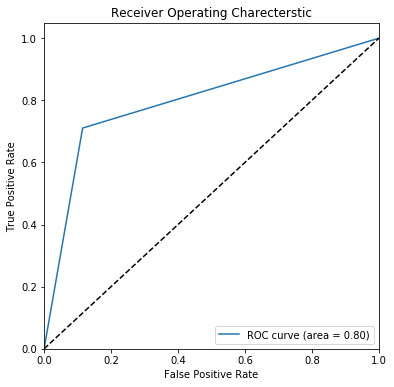

In [62]:
draw_roc(train_y_pred_final.Converted,train_y_pred_final.Predicted)

#### Lets find the optimal cutoff point

In [63]:
# Columns with different probability cutoff
numbers = [float(x/10) for x in range(10)]
for i in numbers:
    train_y_pred_final[i] = train_y_pred_final.Converted_Prob.map(lambda x : 1 if x>i else 0 )
train_y_pred_final.head()

,Converted,Converted_Prob,Cust_ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.852533,8105,1,1,1,1,1,1,1,1,1,1,0
1,0,0.611647,6856,1,1,1,1,1,1,1,1,0,0,0
2,0,0.102399,8272,0,1,1,0,0,0,0,0,0,0,0
3,1,0.590738,1615,1,1,1,1,1,1,1,0,0,0,0
4,1,0.229925,7263,0,1,1,1,0,0,0,0,0,0,0


#### Lets check the sensitivity and specificty tradeoff

In [64]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1  = confusion_matrix(train_y_pred_final.Converted,train_y_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[i,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.386914  1.000000  0.000000
0.1   0.1  0.596931  0.968267  0.362582
0.2   0.2  0.745234  0.918163  0.636100
0.3   0.3  0.801939  0.841336  0.777075
0.4   0.4  0.814863  0.781628  0.835837
0.5   0.5  0.817447  0.710647  0.884848
0.6   0.6  0.800323  0.596242  0.929117
0.7   0.7  0.785622  0.524008  0.950725
0.8   0.8  0.769628  0.451357  0.970487
0.9   0.9  0.717609  0.288935  0.988142


<Figure size 720x432 with 0 Axes>

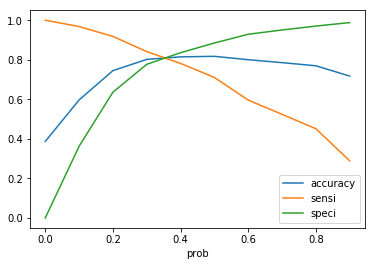

In [65]:
plt.figure(figsize=(10,6))
cutoff_df.plot.line(x = 'prob',y= ['accuracy','sensi','speci'])

#### From the curve we are taking 0.3 as our cutoff probability

In [66]:
train_y_pred_final['Final_Prediction'] = train_y_pred_final.Converted_Prob.map(lambda x:1 if x>0.3 else 0)

In [67]:
train_y_pred_final.head()

,Converted,Converted_Prob,Cust_ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Final_Prediction
0,0,0.852533,8105,1,1,1,1,1,1,1,1,1,1,0,1
1,0,0.611647,6856,1,1,1,1,1,1,1,1,0,0,0,1
2,0,0.102399,8272,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0.590738,1615,1,1,1,1,1,1,1,0,0,0,0,1
4,1,0.229925,7263,0,1,1,1,0,0,0,0,0,0,0,0


#### Lets check the accuracy score of the model again

In [68]:
accuracy_score(train_y_pred_final.Converted,train_y_pred_final.Final_Prediction)

0.8019386106623586

#### Lets check the Confusion metrix

In [69]:
confusion = confusion_matrix(train_y_pred_final.Converted,train_y_pred_final.Final_Prediction)
confusion

array([[2949,  846],
       [ 380, 2015]], dtype=int64)

#### Now lets calculate all the measures for this model and understand how our model is performing

In [70]:
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]

In [71]:
# Sensitivity
TP/float(TP+FN)

0.8413361169102297

In [72]:
# Specificity
TN/float(TN+FP)

0.7770750988142292

In [73]:
# True positive rate
TP/float(TP+FN)

0.8413361169102297

In [74]:
# False positive rate
1-(TN/float(TN+FP))

0.2229249011857708

In [75]:
# Positive predicted value
TP/float(TP+FP)

0.7042991960852849

In [76]:
# Negative predicted value
TN/float(TN+FN)

0.885851607089216

#### Now lets calculate precision(Amount of 1 predicted are actually correct) and recall(Same as sensitivity)

In [77]:
# Precision
#TP/float(TP+FP)
precision_score(train_y_pred_final.Converted,train_y_pred_final.Final_Prediction)

0.7042991960852849

In [78]:
# Recall
#TP/float(TP+FN)
recall_score(train_y_pred_final.Converted,train_y_pred_final.Final_Prediction)

0.8413361169102297

#### Lets see the precision recall tradeoff curve

In [79]:
from sklearn.metrics import precision_recall_curve
pre,rec,thr = precision_recall_curve(train_y_pred_final.Converted,train_y_pred_final.Converted_Prob)

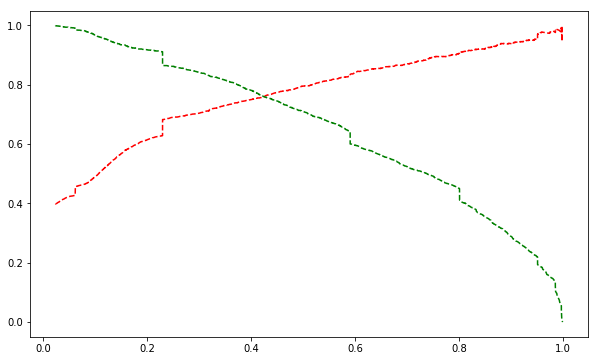

In [80]:
plt.figure(figsize=(10,6))
plt.plot(thr,pre[:-1],'r--')
plt.plot(thr,rec[:-1],'g--')
plt.show()

### Now lets make prediction on the test dataset

#### Lets first scale the data depend on our learning from the train set

In [81]:
test_X[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(test_X[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

#### Selecting the columns from the final model

In [82]:
sel_col = list(X_train_m7.drop('const',axis=1).columns)
test_X = test_X[sel_col]

In [83]:
X_test_sm = sm.add_constant(test_X)

#### Making predictions

In [84]:
test_y_prob = logm7.predict(X_test_sm)

In [85]:
y_test_1 = pd.DataFrame(test_y_prob)

In [86]:
y_test_1.sample(3)

,0
7430,0.028846
7035,0.131266
5602,0.669525


In [87]:
test_y_df = pd.DataFrame(test_y)

In [88]:
test_y_df['ID'] = test_y_df.index

#### Dropping the index for merging

In [89]:
y_test_1.reset_index(drop=True,inplace=True)
test_y_df.reset_index(drop=True,inplace=True)

In [90]:
test_y_final = pd.concat([test_y_df,y_test_1],axis='columns')
test_y_final= test_y_final.rename(columns={ 0 : 'Convert_Prob'})
test_y_final = test_y_final.reindex_axis(['ID','Converted','Convert_Prob'], axis=1)

In [91]:
test_y_final['Final_Prediction'] = test_y_final.Convert_Prob.map(lambda x:1 if x>0.3 else 0)

In [92]:
test_y_final.head()

,ID,Converted,Convert_Prob,Final_Prediction
0,2271,1,0.901963,1
1,2707,0,0.035429,0
2,2061,1,0.757377,1
3,8216,0,0.111752,0
4,570,0,0.187805,0


### Lets calculate all the metrics for the test model

In [93]:
# Accuracy Score
accuracy_score(test_y_final.Converted,test_y_final.Final_Prediction)

0.7901281085154483

In [94]:
# Confusion metrix
conf_test = confusion_matrix(test_y_final.Converted,test_y_final.Final_Prediction)
conf_test

array([[1271,  385],
       [ 172,  826]], dtype=int64)

In [95]:
TP = conf_test[1,1]
TN = conf_test[0,0]
FP = conf_test[1,1]
FN = conf_test[1,0]

In [96]:
# Sensitivity 
TP/float(TP+FN)

0.8276553106212425

In [97]:
# Specificity
TN/float(TN+FP)

0.6061039580352885

In [98]:
# Positives actually correct
TP/float(TP+FP)

0.5

In [99]:
# Precision 
precision_score(test_y_final.Converted,test_y_final.Final_Prediction)

0.6820809248554913

In [100]:
# Recall
recall_score(test_y_final.Converted,test_y_final.Final_Prediction)

0.8276553106212425

#### Now lets assign a sore to all the leads

In [101]:
test_y_final['Lead Score'] = round((test_y_final.Convert_Prob * 100),2)

#### Top 5 Leads

In [102]:
test_y_final.sort_values(by='Lead Score',ascending=False).head()

,ID,Converted,Convert_Prob,Final_Prediction,Lead Score
1767,7219,1,0.999719,1,99.97
761,3478,1,0.999493,1,99.95
414,8074,1,0.999454,1,99.95
232,6383,1,0.999465,1,99.95
2040,7579,1,0.999019,1,99.90
